In [1]:
import numpy as np
import pandas
import statsmodels.api as sm
from statsmodels.tsa.api import VAR

from mne_connectivity import vector_auto_regression

import seaborn as sns
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

# Generate Data

In [2]:
rng = np.random.RandomState(0)

In [5]:
mdata = sm.datasets.macrodata.load_pandas().data

# prepare the dates index
dates = mdata[['year', 'quarter']].astype(int).astype(str)

quarterly = dates["year"] + "Q" + dates["quarter"]

from statsmodels.tsa.base.datetools import dates_from_str

quarterly = dates_from_str(quarterly)

mdata = mdata[['realgdp','realcons','realinv']]

mdata.index = pandas.DatetimeIndex(quarterly)

data = np.log(mdata).diff().dropna()

In [6]:
print(data.shape)

(202, 3)


In [7]:
print(data.to_numpy().shape)

(202, 3)


In [9]:
times = np.arange(202)

# Order-1 Model Fits

## Apply MNE-Conn models

In [10]:
conn = vector_auto_regression(data.to_numpy().T[np.newaxis, ...], times=times, n_jobs=-1, model_order=1)

100%|██████████| 1/1 [00:00<00:00, 93.47it/s]


In [11]:
print(conn)

<EpochConnectivity | , nave : 1, nodes, n_estimated : 3, 9, ~9 kB>


<AxesSubplot:>

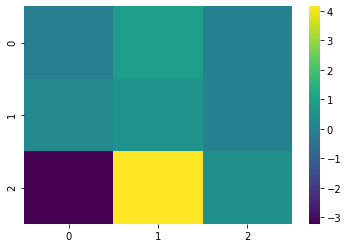

In [12]:
sns.heatmap(conn.get_data(output='dense').squeeze(), cmap='viridis')

# Apply statsmodels VAR

In [13]:
model = VAR(data)

/Users/adam2392/miniforge3/envs/mne/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  warnings.warn('No frequency information was'


In [14]:
results = model.fit(1, trend='nc')

(1, 3, 3)


<AxesSubplot:>

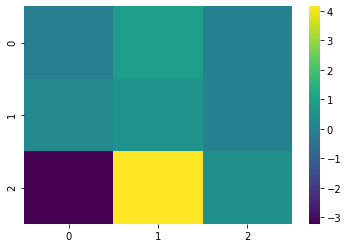

In [15]:
coef = results.coefs
print(coef.shape)

sns.heatmap(coef.squeeze(), cmap='viridis')

In [16]:
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 10, Aug, 2021
Time:                     23:42:15
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -27.3684
Nobs:                     201.000    HQIC:                  -27.4565
Log likelihood:           1918.77    FPE:                1.12156e-12
AIC:                     -27.5163    Det(Omega_mle):     1.07281e-12
--------------------------------------------------------------------
Results for equation realgdp
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
L1.realgdp         -0.111991         0.167977           -0.667           0.505
L1.realcons         0.844184         0.132588            6.367           0.000
L1.realinv          0.023873         0.024671            0.968    

In [17]:
print(np.linalg.norm(coef - conn.get_data(output='dense')))
np.testing.assert_array_almost_equal(coef, conn.get_data(output='dense'))

9.60115771017561e-15


# Model Order 2 Fits

In [20]:
model_order = 2

In [21]:
conn = vector_auto_regression(data.to_numpy().T[np.newaxis, ...], model='avg-epochs', 
                              times=times, n_jobs=-1, model_order=model_order)

(3, 6)


In [22]:
print(data.to_numpy().T[np.newaxis, ...].shape)

(1, 3, 202)


In [23]:
print(conn)

print(conn.get_data(output='dense').shape)

<Connectivity | , nave : 1, nodes, n_estimated : 3, 18, ~9 kB>
(3, 6)


In [25]:
results = model.fit(model_order, trend='nc')

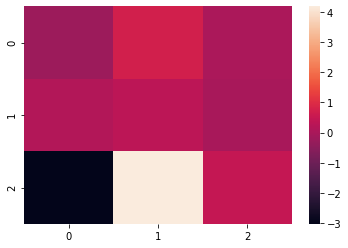

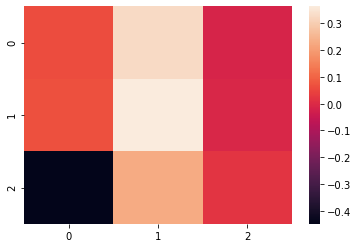

In [26]:
for idx in range(model_order):
    plt.figure()
    sns.heatmap(results.coefs[idx, ...])

In [30]:
print(results.coefs.flatten().shape)
print(conn.get_data().shape)

(18,)
(18,)


In [32]:
for idx in range(model_order):
    np.testing.assert_array_almost_equal(results.coefs[idx, ...], conn.get_data(output='dense')[:, idx:3*(idx+1)])

AssertionError: 
Arrays are not almost equal to 6 decimals

Mismatched elements: 6 / 9 (66.7%)
Max absolute difference: 4.62575709
Max relative difference: 10.32676849
 x: array([[-0.212227,  0.690114,  0.0195  ],
       [ 0.139829,  0.322623, -0.023314],
       [-3.023011,  4.177819,  0.440236]])
 y: array([[-0.212227,  0.061163,  0.690114],
       [ 0.139829,  0.066116,  0.322623],
       [-3.023011, -0.447938,  4.177819]])